# RL and Advanced DL: Домашнее задание 1

- Первое ДЗ связано с обучением с подкреплением, и оно придумано для ситуации, когда нейронные сети ещё не нужны, и пространство состояний в целом достаточно маленькое, чтобы можно было обучить хорошую стратегию методами TD-обучения или другими методами обучения с подкреплением. Задание получилось, надеюсь, интересное, но в том числе и достаточно техническое, так что для решения придётся немножко попрограммировать. **Поэтому в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии**. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.

In [1]:
# импортируем необходимые библиотеки
import gym
import itertools
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from gym import spaces
from gym.utils import seeding

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## Часть первая, с блекджеком и стратегиями

Мы будем обучаться играть в очень простую, но знаменитую и популярную игру: блекджек. 
Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:
- численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
- туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;
- игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
- игрок может совершать одно из двух действий:
- hit  — взять ещё одну карту;
- stand — не брать больше карт;
- если сумма очков у игрока на руках больше 21, он проигрывает (bust);
- если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
- после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
- в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).
Именно этот простейший вариант блекджека реализован в OpenAI Gym:
1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.
2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v1 из OpenAI Gym.
3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

### 1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [2]:
# загружаем среду игры Блекдже
env = gym.make('Blackjack-v1')
# инициализируем действия взять и остановиться
actions = {'stand': 0, 'hit': 1}
revers_actions = {}
# переопределим действия
for k, v in actions.items():
    revers_actions[v] = k

In [3]:
def simple_policy(
    observation,
    actions
):
    """
    Стратегия комбинаций.
    """
    # если у нас 19, 20 или 21 останавливаемся, в противном случае берем.
    list_action = [19, 20, 21]
    if observation in list_action:
        action = 'stand'
    else:
        action = 'hit'
        
    return actions[action]


def run_policy(
    n,
    actions
):
    """
    Запуск определения выигрыша от стратегии.
    """
    # определим список для записи награды
    rewards = []
    for i in range(n):
        observation = env.reset()
        steps = 0
        while True:
            # определяем стратегию действия
            action = simple_policy(observation[0], actions)
            if action == actions['hit']:
                steps += 1
            # делаем шаг
            observation, reward, done, info = env.step(action)
            if done:
                rewards.append(reward)
                break
                
    return rewards

In [4]:
# число проходов
n = 100000
# запуск прохода
rewards = run_policy(n, actions)
print(f'Средний ожидаемый выигрыш: {np.mean(rewards)}')

Средний ожидаемый выигрыш: -0.20084


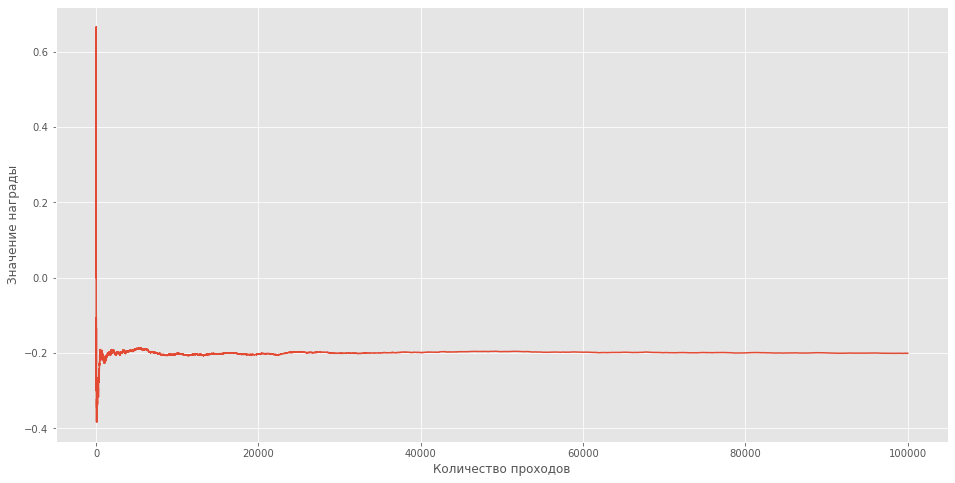

In [5]:
# визуализируем среднюю награду для простой стратегии
plot_rewards = []
for iterr in range(len(rewards)):
    plot_rewards.append(sum(rewards[:iterr]) / (iterr+1))
plt.figure(figsize=(16, 8))
plt.plot(plot_rewards)
plt.xlabel('Количество проходов')
plt.ylabel('Значение награды')
plt.grid(True)
plt.show()

#### Вывод:
Если мы просто используем случайную стратегию для получения выигрыша, то результаты получаются отрицательными, так как мы не можем четко определять наши ходы и взвешивать все решения, основываясь на опыте. Скорее всего мы все проиграем)))

### 2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v1 из OpenAI Gym.

In [6]:
def epsilon_soft_policy(
    epsilon,
    Q_state
):
    """
    Подход на основе эпсилон мягкий стратегии.
    """
    if np.random.rand() > epsilon: 
        val_policy = np.argmax(Q_state)
    else:
        val_policy = np.random.randint(len(Q_state))
    
    return val_policy


def run_episode_game(
    env,
    policy,
    Q,
    epsilon
):
    """
    Запуск прохода игры по эпизодам.
    """
    # списки для записи действия, награды и наблюдений
    observations, actions, rewards = [], [], []
    observation = env.reset()
 
    while True:
        observation = observation[:2]
        action = policy(epsilon, Q[observation])
        next_observation, reward, done, _ = env.step(action)
        
        # записываем результаты
        observations.append(observation)
        actions.append(action)
        rewards.append(reward)
        observation = next_observation

        if done:
            break

    return observations, actions, rewards


def monte_carlo_control(
    env,
    Q,
    policy,
    gamma,
    epsilon,
    weights
):
    """
    Обучение Монте-Карло.
    """
    states, actions, rewards = run_episode_game(env, policy, Q, epsilon)
    G, W = 0, 1
    best_action = 1 - (env.action_space.n - 1) * epsilon / env.action_space.n

    for iterr in range(len(rewards))[::-1]:
        state_new = states[iterr]
        action_new = actions[iterr]
        reward_new = rewards[iterr]
        # определение гаммы на основе награды
        G = gamma * G + reward_new
        weights[(state_new, action_new)] += W
        Q[state_new][action_new] += (G - Q[state_new][action_new]) * W / weights[(state_new, action_new)]
        action_optimal = np.argmax(Q[state_new])
        if action_optimal != action_new:
            break

        W = W / best_action
        
        
def run_algorithms(
    env,
    Q,
    n
):
    """
    Запуск определения среднего выигрыша от стратегии.
    """
    # инициализация списка наград
    rewards = []
    for i in range(n):
        observation = env.reset()
        while True:
            action = Q[observation[:2]].argmax()
            observation, reward, done, _ = env.step(action)
            if done:
                rewards.append(reward)
                break
                
    return np.mean(rewards)


def results_monte_carlo(
    env,
    update_Q,
    eps_policy,
    iterr_freq,
    gamma,
    epsilon,
    n
):
    """
    Получение результатов работы стратегии на основе Монте-Карло.
    """
    # инициализация списка наград
    results = []
    # инициализаия Q функции
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # инициализация весов
    weights = defaultdict(lambda: 0)
    
    # проход по стратегии
    for iterr in range(n + 1):
        # обновление Q функции
        update_Q(env, Q, eps_policy, gamma, epsilon, weights)

        if iterr % iterr_freq == 0:
            result = run_algorithms(env, Q, 1000)
            results.append(result)

    return results, Q

In [7]:
# инициализация параметров
res_monte_carlo = {}
# количество проходов
n = 10000
iterr_freq = 100
# значение гаммы
gamma = 0.5
# значение эпсилон
epsilon = 0.05
# определение награды и значение Q функции
rewards, Q = results_monte_carlo(env, monte_carlo_control, epsilon_soft_policy, iterr_freq, gamma, epsilon, n) 
# запуск прохода
res_monte_carlo[(gamma, epsilon)] = (rewards, Q)
print(f'Средний ожидаемый выигрыш: {np.mean(rewards)}')

Средний ожидаемый выигрыш: -0.11917821782178217


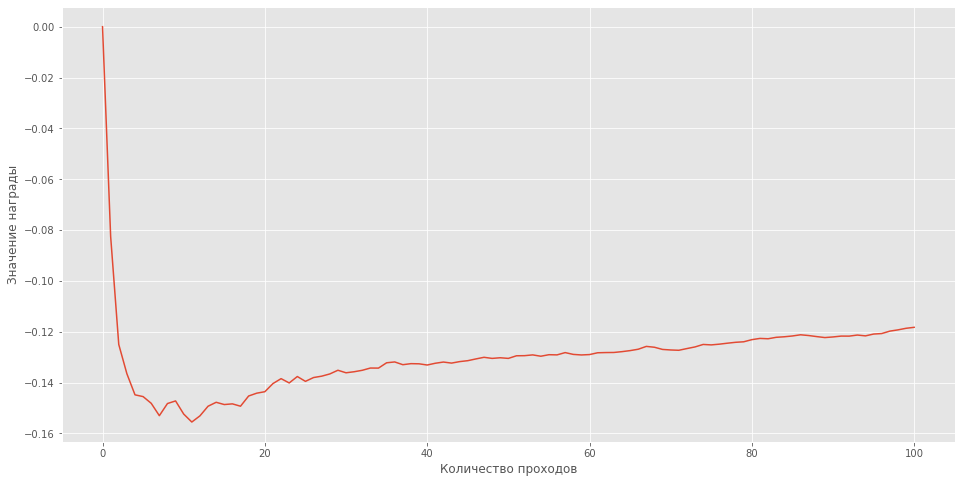

In [8]:
# визуализируем среднюю награду для простой стратегии
plot_rewards = []
for iterr in range(len(rewards)):
    plot_rewards.append(sum(rewards[:iterr]) / (iterr+1))
plt.figure(figsize=(16, 8))
plt.plot(plot_rewards)
plt.xlabel('Количество проходов')
plt.ylabel('Значение награды')
plt.grid(True)
plt.show()

### 3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

In [9]:
# инициализация параметров
res_monte_carlo = {}
# количество проходов
n = 10000
iterr_freq = 100
# значение гаммы подбора
gamma_many = [0.1, 0.25, 0.5, 1]
# значение эпсилон для подбора
epsilon_many = [0.1, 0.25, 0.5, 1]
# значение оптимальной награды
best_mean_reward = -float('inf')

# определение награды и значение Q функции
for gamma, epsilon in itertools.product(gamma_many, epsilon_many):
    rewards, Q = results_monte_carlo(env, monte_carlo_control, epsilon_soft_policy, iterr_freq, gamma, epsilon, n) 
    # запуск прохода
    res_monte_carlo[(gamma, epsilon)] = (rewards, Q)
    mean_reward = np.mean(rewards)
    
    if mean_reward > best_mean_reward:
        best_mean_reward = mean_reward
        best_params = (gamma, epsilon)
print(f'Оптимальное значение для gamma = {best_params[0]} и для epsilon = {best_params[1]}')
print(f'Средний ожидаемый выигрыш = {best_mean_reward}')

Оптимальное значение для gamma = 0.25 и для epsilon = 0.5
Средний ожидаемый выигрыш = -0.07834653465346535


[]

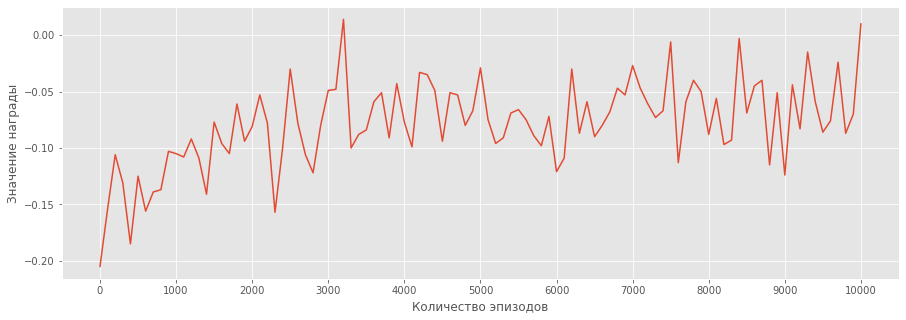

In [10]:
# строим результаты обучения
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
results = res_monte_carlo[best_params][0]
ax.plot(results)
ax.set_xlabel('Количество эпизодов')
ax.set_ylabel('Значение награды')
ax.set_xticks(list(range(len(results)))[::10])
ax.set_xticklabels(list(range(0, n + 1, iterr_freq))[::10])
plt.plot()

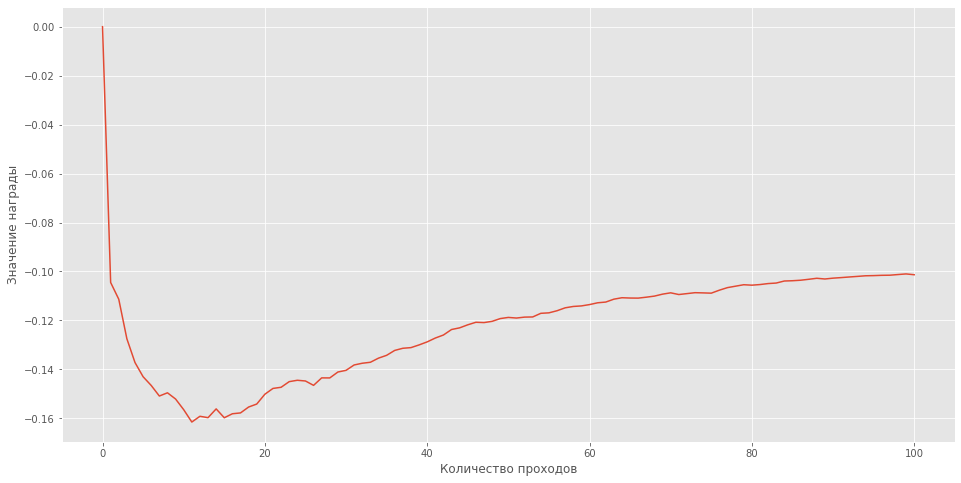

In [11]:
# визуализируем среднюю награду для простой стратегии
plot_rewards = []
for iterr in range(len(rewards)):
    plot_rewards.append(sum(rewards[:iterr]) / (iterr+1))
plt.figure(figsize=(16, 8))
plt.plot(plot_rewards)
plt.xlabel('Количество проходов')
plt.ylabel('Значение награды')
plt.grid(True)
plt.show()

#### Вывод:
С применением метода Монте-Карло результаты становятся уже лучше и здесь, хоть мы и выходим в минус по выигрышу, но побеждаем чаще, но все же не учитываем всю историю и опыт предыдущих раздач для максимизации выигрыша.

## Часть вторая, удвоенная

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:
- **double** — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.
4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v1 из OpenAI Gym, в котором разрешено удвоение ставки.
5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

### 4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v1 из OpenAI Gym, в котором разрешено удвоение ставки.

In [12]:
# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

class DoublBlackjackEnv(gym.Env):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        elif action == 0:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        elif action == 2:
            self.player.append(draw_card(self.np_random))
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer)) * 2

        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()
    

def cmp(a, b):
    return float(a > b) - float(a < b)


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]

In [13]:
env = DoublBlackjackEnv()
# инициализируем действия взять и остановиться
actions = {'stand': 0, 'hit': 1}
revers_actions = {}
# переопределим действия
for k, v in actions.items():
    revers_actions[v] = k

In [14]:
# инициализация параметров
res_monte_carlo = {}
# количество проходов
n = 10000
iterr_freq = 100
# значение гаммы
gamma = 0.5
# значение эпсилон
epsilon = 0.05
# определение награды и значение Q функции
rewards, Q = results_monte_carlo(env, monte_carlo_control, epsilon_soft_policy, iterr_freq, gamma, epsilon, n) 
# запуск прохода
res_monte_carlo[(gamma, epsilon)] = (rewards, Q)
print(f'Средний ожидаемый выигрыш: {np.mean(rewards)}')

Средний ожидаемый выигрыш: -0.12283168316831684


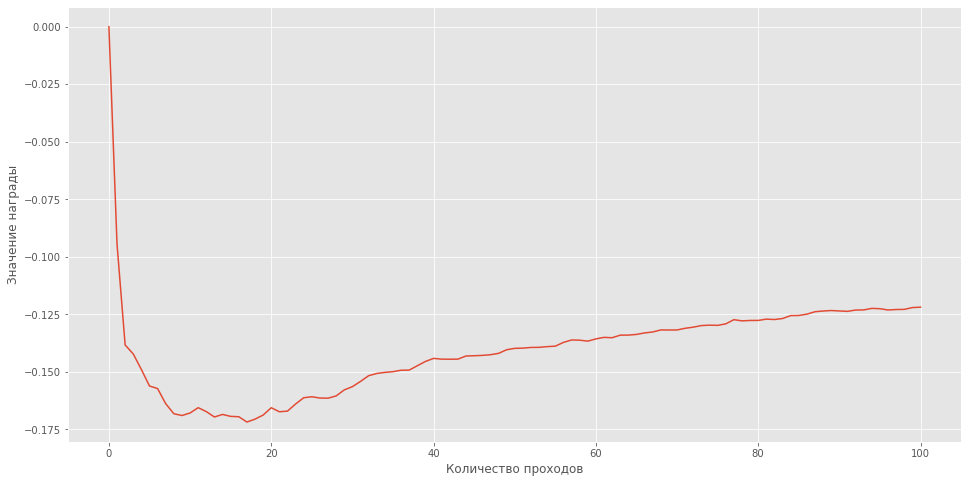

In [15]:
# визуализируем среднюю награду для простой стратегии
plot_rewards = []
for iterr in range(len(rewards)):
    plot_rewards.append(sum(rewards[:iterr]) / (iterr+1))
plt.figure(figsize=(16, 8))
plt.plot(plot_rewards)
plt.xlabel('Количество проходов')
plt.ylabel('Значение награды')
plt.grid(True)
plt.show()

In [16]:
# инициализация параметров
res_monte_carlo = {}
# количество проходов
n = 10000
iterr_freq = 100
# значение гаммы подбора
gamma_many = [0.1, 0.25, 0.5, 1]
# значение эпсилон для подбора
epsilon_many = [0.1, 0.25, 0.5, 1]
# значение оптимальной награды
best_mean_reward = -float('inf')

# определение награды и значение Q функции
for gamma, epsilon in itertools.product(gamma_many, epsilon_many):
    rewards, Q = results_monte_carlo(env, monte_carlo_control, epsilon_soft_policy, iterr_freq, gamma, epsilon, n) 
    # запуск прохода
    res_monte_carlo[(gamma, epsilon)] = (rewards, Q)
    mean_reward = np.mean(rewards)
    
    if mean_reward > best_mean_reward:
        best_mean_reward = mean_reward
        best_params = (gamma, epsilon)
print(f'Оптимальное значение для gamma = {best_params[0]} и для epsilon = {best_params[1]}')
print(f'Средний ожидаемый выигрыш = {best_mean_reward}')

Оптимальное значение для gamma = 0.25 и для epsilon = 0.25
Средний ожидаемый выигрыш = -0.09700990099009901


[]

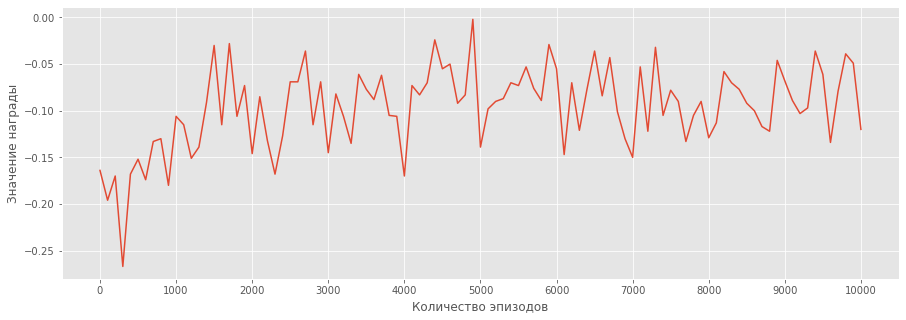

In [17]:
# строим результаты обучения
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
results = res_monte_carlo[best_params][0]
ax.plot(results)
ax.set_xlabel('Количество эпизодов')
ax.set_ylabel('Значение награды')
ax.set_xticks(list(range(len(results)))[::10])
ax.set_xticklabels(list(range(0, n + 1, iterr_freq))[::10])
plt.plot()

#### Вывод:
С применением метода Монте-Карло для случая с удвоением ставки, мы видим, что в некоторых случаях алгоритм действительно рекомендует удваивать ставку. Но все равно результаты средней награды по всем проходам хуже, чем у обычного подхода.

## Часть третья, в главной роли — Дастин Хоффман

А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.
Думаю, у вас уже возникла в голове эта картинка:
Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.

6. Реализуйте вариант окружения Blackjack-v1 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет);

7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [18]:
# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

rule_count = {1: -2, 2: 1, 3: 2, 4: 2, 5: 3, 6: 2, 7: 1, 8: 0, 9: -1, 10: -2}

class HoffDoublBlackjackEnv(gym.Env):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        self.deck = deck[:] * 4
        self.score = 0

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def draw_card(self):
        card = np.random.choice(self.deck)
        self.deck.remove(card)
        self.score += rule_count[card]
        return card

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(self.draw_card())
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        elif action == 0:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card())
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        elif action == 2:
            self.player.append(self.draw_card())
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card())
            reward = cmp(score(self.player), score(self.dealer)) * 2

        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        # limit min and max values
        score = self.score
        if score < -20:
            score = -20
        elif score > 20:
            score = 20

        return (sum_hand(self.player), self.dealer[0], score, usable_ace(self.player))

    def reset(self):
        if len(self.deck) < 15:
            self.deck = deck[:] * 4
            self.score = 0

        self.dealer = [self.draw_card()]
        self.player = [self.draw_card(), self.draw_card()]
        return self._get_obs()


def cmp(a, b):
    return float(a > b) - float(a < b)


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]

In [19]:
env = HoffDoublBlackjackEnv()
# инициализируем действия взять и остановиться
actions = {'stand': 0, 'hit': 1}
revers_actions = {}
# переопределим действия
for k, v in actions.items():
    revers_actions[v] = k

In [20]:
# инициализация параметров
res_monte_carlo = {}
# количество проходов
n = 10000
iterr_freq = 100
# значение гаммы
gamma = 0.5
# значение эпсилон
epsilon = 0.05
# определение награды и значение Q функции
rewards, Q = results_monte_carlo(env, monte_carlo_control, epsilon_soft_policy, iterr_freq, gamma, epsilon, n) 
# запуск прохода
res_monte_carlo[(gamma, epsilon)] = (rewards, Q)
print(f'Средний ожидаемый выигрыш: {np.mean(rewards)}')

Средний ожидаемый выигрыш: -0.13378217821782182


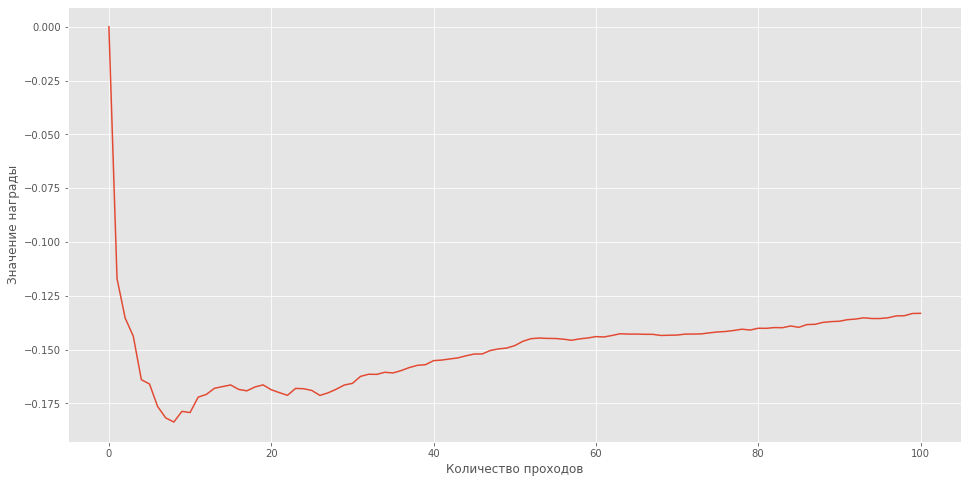

In [21]:
# визуализируем среднюю награду для простой стратегии
plot_rewards = []
for iterr in range(len(rewards)):
    plot_rewards.append(sum(rewards[:iterr]) / (iterr+1))
plt.figure(figsize=(16, 8))
plt.plot(plot_rewards)
plt.xlabel('Количество проходов')
plt.ylabel('Значение награды')
plt.grid(True)
plt.show()

In [22]:
# инициализация параметров
res_monte_carlo = {}
# количество проходов
n = 10000
iterr_freq = 100
# значение гаммы подбора
gamma_many = np.arange(0.1, 0.25, 0.5)
# значение эпсилон для подбора
epsilon_many = np.arange(0.1, 0.25, 0.5)
# значение оптимальной награды
best_mean_reward = -float('inf')

# определение награды и значение Q функции
for gamma, epsilon in itertools.product(gamma_many, epsilon_many):
    rewards, Q = results_monte_carlo(env, monte_carlo_control, epsilon_soft_policy, iterr_freq, gamma, epsilon, n) 
    # запуск прохода
    res_monte_carlo[(gamma, epsilon)] = (rewards, Q)
    mean_reward = np.mean(rewards)
    
    if mean_reward > best_mean_reward:
        best_mean_reward = mean_reward
        best_params = (gamma, epsilon)
print(f'Оптимальное значение для gamma = {best_params[0]} и для epsilon = {best_params[1]}')
print(f'Средний ожидаемый выигрыш = {best_mean_reward}')

Оптимальное значение для gamma = 0.1 и для epsilon = 0.1
Средний ожидаемый выигрыш = -0.10215841584158414


[]

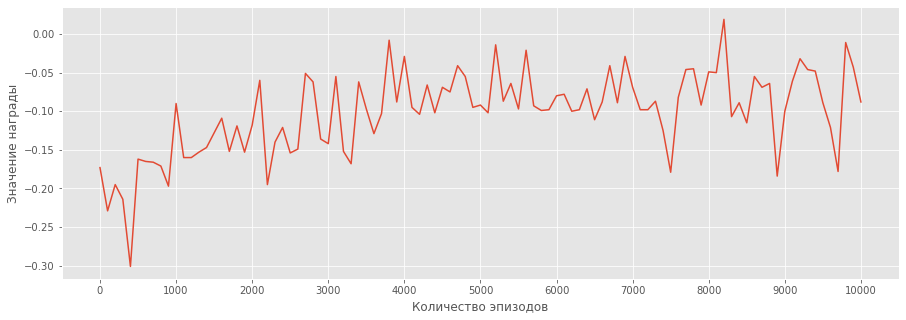

In [23]:
# строим результаты обучения
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
results = res_monte_carlo[best_params][0]
ax.plot(results)
ax.set_xlabel('Количество эпизодов')
ax.set_ylabel('Значение награды')
ax.set_xticks(list(range(len(results)))[::10])
ax.set_xticklabels(list(range(0, n + 1, iterr_freq))[::10])
plt.plot()

#### Вывод:
С применением метода Монте-Карло для случая с удвоением ставки по Дастину Хоффману, мы видим, что данный подход является наиболее оптимальным и приносит самый хороший выигрыш из всех предыдущих подходов. В целом, если еще реализовать подход на основе Q-learning и заглядывать на шаг назад с возможностью отсекать не правильные ходы, то можно добиться положительного результат :)